In [1]:
import pandas as pd
from IPython.display import display
import numpy as np

import pathlib as pl
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

%matplotlib inline

In [2]:
def remove_numerics(s):
    return ''.join(i for i in s if not i.isdigit())
def filename_process(s):
    _s = remove_numerics(s)
    return _s.replace(".txt","").replace(".","")

In [33]:
class WFSingleResultsReader(object):
    def __init__(self, path):
        assert type(path) in [pl.PosixPath, str], "path should be of type string or pl.PosixPath"
        self.pl_path = WFSingleResultsReader.inst_path(path)
        self.Mterm = self.read_mterm()
        self.Mterms = self.read_mterm(plural=True)
        self.mterm_nwavelets = self.read_mterm_nwavelets()
        self.threshold = self.read_threshold()
        self.mterm_error = self.read_mterm_err()
        self.error_by_forest = self.read_error_by_forest()
        self.nwavelets = self.read_nwavelets()
        
        self.alpha_mterm = self.read_alpha_mterm()
        
    @staticmethod
    def inst_path(path):
        return path if type(path) == pl.PosixPath else pl.Path(path)
    
    def read_threshold(self):
        return pd.read_csv(self.pl_path.joinpath("threshold.txt"), names=["t"],dtype={'t':np.float64}, squeeze=True).values[0]
    
    def read_mterm(self, plural = False):
        _s = "Mterms.txt" if plural else "Mterm.txt"
        return pd.read_csv(self.pl_path.joinpath(_s), names=["MT"], squeeze=True).values[0]
    
    def read_mterm_err(self):
        _d = {"Training":None, "Testing":None, "Validating":None}
        for k in _d.keys():
            _d[k] = pd.read_csv(self.pl_path.joinpath("mTermErrorOn{}.txt".format(k)), names=['error'])
            _d[k]['nWavelets']= self.mterm_nwavelets
        return _d
    
    def read_error_by_forest(self):
        _d = {"Train":None, "Test":None, "Valid":None}
        for k in _d.keys():
            _d[k] = pd.DataFrame(columns=['None', self.threshold])
            _d[k]["None"] = pd.read_csv(self.pl_path.joinpath("{}errorByForest.txt".format(k)), names=['None'], squeeze=True)
            thresh_path = list(self.pl_path.glob("{}errorByForestWithThreshold{}*.txt".format(k,str(self.threshold)[:4])))[0]
            _d[k][self.threshold] = pd.read_csv(self.pl_path.joinpath(thresh_path.name), names=[self.threshold], squeeze=True)
        return _d
    
    def read_nwavelets(self):
        _d = pd.DataFrame(columns=['None', self.threshold])
        _d["None"] = pd.read_csv(self.pl_path.joinpath("NwaveletsInRF.txt"), names=['None'], squeeze=True)
#         _d[self.threshold] = pd.read_csv(self.pl_path.joinpath("NwaveletsInRFWithThreshold{}.txt".format(self.threshold)), names=[self.threshold], squeeze=True)
        return _d
    
    def read_mterm_nwavelets(self):
        return pd.read_csv(self.pl_path.joinpath("mTermNwavelets.txt"), names=['mTermNwavelets'], squeeze=True)
    
    def read_alpha_mterm(self):
        return pd.read_csv(self.pl_path.joinpath("alphaMterm.txt"), names=['alphaMterm'], squeeze=True).values[0]
    
class WFDirectoryReader(object):
    def __init__(self, path):
        assert type(path) in [pl.PosixPath, str], "path should be of type string or pl.PosixPath"
        self.pl_path = WFSingleResultsReader.inst_path(path)
        self.rf_list = list(map(lambda x:WFSingleResultsReader(x), [d for d in self.pl_path.iterdir() if d.is_dir()]))
        self.nwavelets = self.melt_nwavelets()
        self.error_by_nwavelets = self.melt_mterm_error()
        self.error_by_tree = self.melt_error_by_tree()
        self.alpha = pd.Series(np.array([wf.alpha_mterm for wf in self.rf_list]))
        
    def melt_nwavelets(self):
        def prep_table(wf, i):
            _d = wf.nwavelets.loc[:,["None"]].reset_index().copy()
            _d['#wf'] = i
            return _d
        
        return pd.concat([prep_table(wf,i) for i,wf in enumerate(self.rf_list)])
    
    def melt_mterm_error(self):
        _d = {"Training":None, "Testing":None, "Validating":None}
        def prep_table(table,i):
            __d = table.copy()
            __d['#wf'] = i
            return __d
        
        for k in _d.keys():
            _d[k] = pd.concat([prep_table(wf.mterm_error[k],i) for i,wf in enumerate(self.rf_list)])
        return _d
    
    def melt_error_by_tree(self):
        _d = {"Train":None, "Test":None, "Valid":None}
        def prep_table(_wf, key,i):
            __d = _wf.error_by_forest[key].copy()
            __d = pd.melt(__d, value_name='Error',var_name='Threshold')
            __d['Threshold'] = __d['Threshold'].apply(lambda x: 'No threshold' if x =='None' else 'With threshold')
            __d['#wf'] = i
            return __d
        
        for k in _d.keys():
            _d[k] = pd.concat([prep_table(wf, k,i) for i,wf in enumerate(self.rf_list)])
        return _d
    
class WFResultsReader(object):
    def __init__(self, path):
        assert type(path) in [pl.PosixPath, str], "path should be of type string or pl.PosixPath"
        self.pl_path = WFSingleResultsReader.inst_path(path)
        self.wf_dict = {'iso': WFDirectoryReader(self.pl_path.joinpath("Isotropic")), 
                  'aniso':WFDirectoryReader(self.pl_path.joinpath("Unisotropic"))}
        self.error_by_nwavelets = self.melt_nwavelets()
        self.error_by_tree = self.melt_error_by_tree()
        self.alpha = self.melt_alpha()
        
    def melt_nwavelets(self):
        _dict = {"Training":None, "Testing":None, "Validating":None}
        for k in _dict.keys():
            _dfl = []
            for m in self.wf_dict.keys():
                _df = self.wf_dict[m].error_by_nwavelets[k].copy()
                _df['method'] = "{}".format(m)
                _dfl.append(_df.copy())
                
            _dict[k] = pd.concat(_dfl)
        return _dict
    
    def melt_alpha(self):
        _dfl = []
        for m in self.wf_dict.keys():
            _df = pd.DataFrame(self.wf_dict[m].alpha.copy(), columns=['alpha'])
            _df['method'] = m
            _dfl.append(_df.copy())
        return pd.concat(_dfl).reset_index(drop=True)
    
    def melt_error_by_tree(self):
        _dict = {"Train":None, "Test":None, "Valid":None}
        for k in _dict.keys():
            _dfl = []
            for m in self.wf_dict.keys():
                _df = self.wf_dict[m].error_by_tree[k].copy()
                _df['method'] = "{}".format(m)
                _dfl.append(_df.copy())
                
            _dict[k] = pd.concat(_dfl)
        return _dict
    
    def plot_error_by_nwavelets(self, size=[20, 6]):
        plt.figure(figsize=size)
        
        for i,k in enumerate(['Training','Testing','Validating']):
            plt.subplot(131+i)
            _a = sns.lineplot(data = self.error_by_nwavelets[k], x='nWavelets', y="error", hue='method', legend='full', ci=100,units="#wf",estimator=None)
            _a.set_title(k)
            plt.tight_layout()
            
    def plot_alpha(self):
        return self.alpha.copy()
            
    def plot_error_by_tree(self, size=[18, 6]):
#         plt.figure(figsize=size)
        param = ['Train','Test','Valid']
#         for i,k in enumerate(param):
#             plt.subplot(131+i)
#             _a = sns.boxplot(data = self.error_by_tree[k], x='method', y="Error", hue='Threshold')
#             _a.set_title(k)
#             if i > 0:
#                 _a.legend_.set_visible(False)
        return pd.concat([self.error_by_tree[k].copy() for k in param])
#         plt.tight_layout()

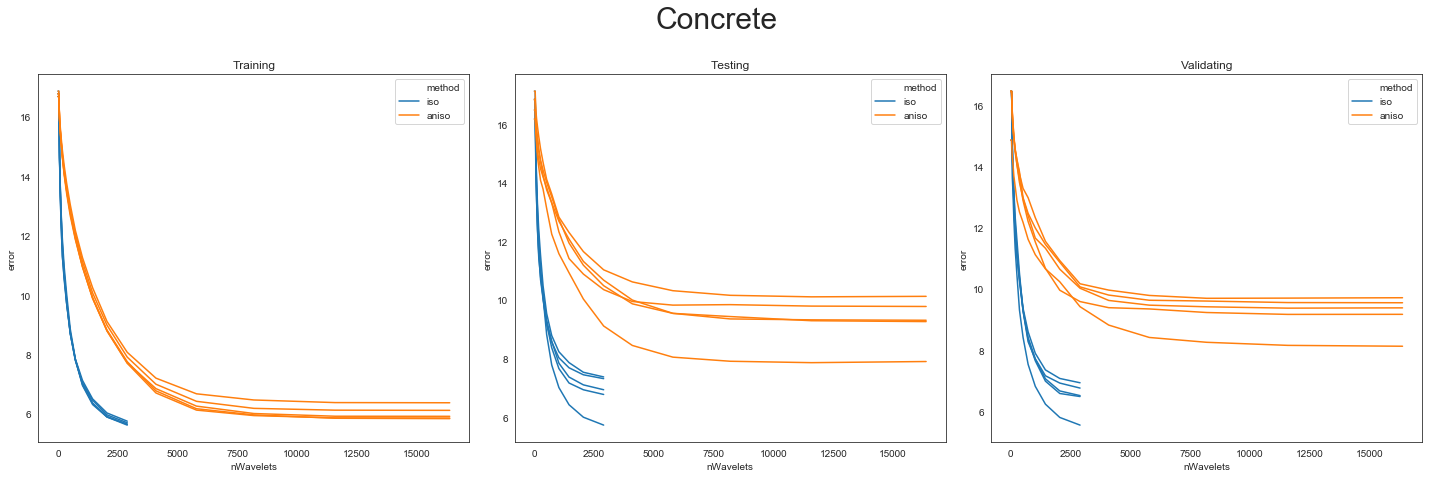

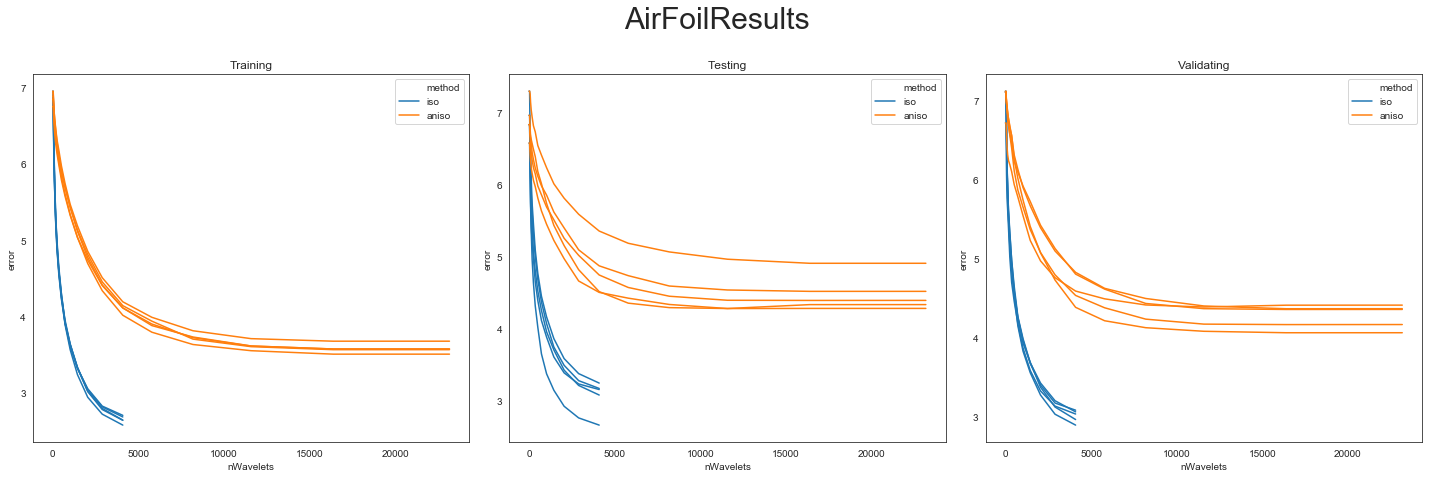

FileNotFoundError: [Errno 2] No such file or directory: '../Parkinson/Isotropic'

In [36]:
dirs = ["Concrete", "AirFoilResults", "Parkinson"]
for d in dirs:
    p = pl.Path("..").joinpath(d)
    
    data = WFResultsReader(p)
    data.plot_error_by_nwavelets()
    plt.suptitle(d, y=1.1,size = 30)
    ebt = data.plot_error_by_tree()
    
    plt.tight_layout()
    plt.show()

In [24]:
edf = pd.DataFrame(columns=['method','threshold','mean','sd'])

for cnt, ((m,t),_df) in enumerate(ebt.groupby(['method','Threshold'])):
    edf.loc[cnt,:] = [m,t,_df['Error'].mean(), _df['Error'].std()]
display(edf)

,method,threshold,mean,sd
0,aniso,No threshold,7.2641,1.67782
1,aniso,With threshold,7.28156,1.68674
2,iso,No threshold,6.06135,1.00564
3,iso,With threshold,6.07713,1.0005
